# Fraud case study



## Day 1: building a fraud model

## Day 2: building an app/dashboard

## Tips success

You will quickly run out of time:

*  Use CRISP-DM workflow to analyze data and build a model
*  Iterate quickly, test often, commit often
*  Build deadlines for your work so you stay on track
*  Should have a model by end of day 1
*  Start app once model is working

### CRISP-DM workflow

Follow the [CRISP-DM](https://en.wikipedia.org/wiki/Cross_Industry_Standard_Process_for_Data_Mining) steps:

1.  Business understanding
2.  Data understanding
3.  Data preparation
4.  Modeling
5.  Evaluation
6.  Deployment

# Introduction to case study: data & problem

Let's look at the data.  What format is the data in?  How do you extract it?

In [ ]:
ls -lh data

Unzip the data so you can load it into Python

In [ ]:
!unzip data/data.zip -d data

Initially, work with a subset at first in order to iterate quickly.  But, the file is one giant line of json:

In [ ]:
!wc data/data.json

Write a quick and dirty script to pull out the first 100 records so we can get code working quickly.

In [ ]:
%%writefile subset_json.py
"""head_json.py - extract a couple records from a huge json file.

Syntax: python head_json.py < infile.json > outfile.json
"""

import sys

start_char = '{'
stop_char = '}'
n_records = 100
level_nesting = 0

while n_records != 0:
    ch = sys.stdin.read(1)
    sys.stdout.write(ch)
    if ch == start_char:
        level_nesting += 1
    if ch == stop_char:
        level_nesting -= 1
        if level_nesting == 0:
            n_records -= 1
sys.stdout.write(']')


In [ ]:
!python subset_json.py < data/data.json > data/subset.json

In [40]:
import pandas as pd

df_original = pd.read_json('data/data.json')

In [ ]:
df.head().T

Some of the data is text (and HTML), which will require feature engineering:

* TF-IDF
* Feature hashing
* n-grams

etc.

You will also need to construct a target from `acct_type`.  Fraud events start with `fraud`.  How you define fraud depends on how you define the business problem.

In [2]:
df.acct_type.value_counts(dropna=False)

premium             12373
fraudster_event       851
fraudster             437
spammer_limited       218
spammer_warn          144
tos_warn               91
spammer_noinvite       84
tos_lock               77
locked                 54
fraudster_att           5
spammer_web             2
spammer                 1
Name: acct_type, dtype: int64

In [ ]:
df.info()

Is missing data a problem?  What are your options for handling missing data?

In [ ]:
df.describe().T

In [3]:
import numpy as np
df['fraud'] = np.where((df['acct_type'] == 'fraudster') | (df['acct_type'] == 'fraudster_event') | (df['acct_type'] == 'fraudster_att'), 1, 0)

In [ ]:
df['org_fb_twitter'] = df['org_facebook'] + df['org_twitter']

In [ ]:
df.boxplot('org_fb_twitter', 'fraud')

In [4]:
boxes = ['delivery_method', 'has_logo', 'name_length', 'org_facebook', 'org_twitter', 'user_age']

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:190: UserWarning: When passing multiple axes, layout keyword is ignored
  "When passing multiple axes, layout keyword is ignored", UserWarning
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:375: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


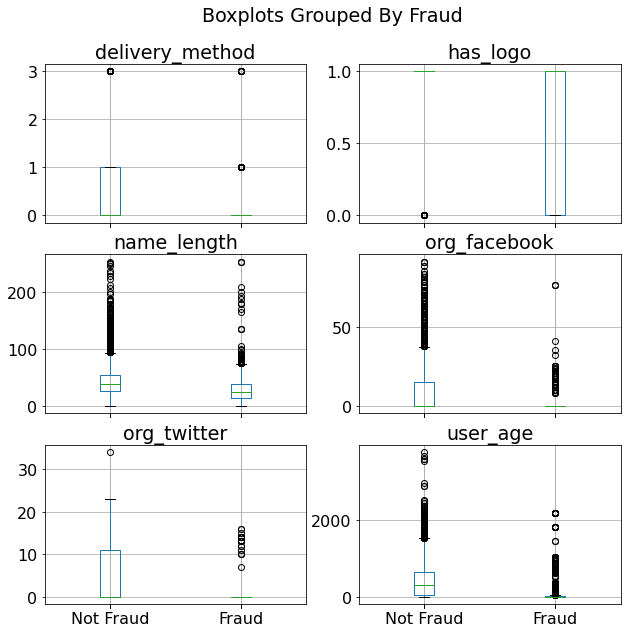

In [38]:
fig, ax_new = plt.subplots(3, 2, sharey=False, figsize=(10,10), sharex=True)
bp = df.boxplot(by="fraud", column=boxes, ax=ax_new,layout=(3, 2), figsize=(10, 10))
[ax_tmp.set_xlabel('') for ax_tmp in ax_new.reshape(-1)]
[ax_tmp.set_xticklabels(['Not Fraud','Fraud']) for ax_tmp in ax_new[2]]
# [ax_tmp.set_xlabel('Fraud') for ax_tmp in ax_new[2]]
fig.suptitle('Boxplots Grouped By Fraud')
# plt.tight_layout()
plt.savefig('images/boxplots.png')

In [41]:
def feature_eng(df):
    # Insert our target of fraud = 1 and not fraud = 0
    df['fraud'] = np.where((df['acct_type'] == 'fraudster') | (df['acct_type'] == 'fraudster_event') | (df['acct_type'] == 'fraudster_att'), 1, 0)

    #break down the email domain into two categories subdomain and tld
    df['subdomain'] = df.apply(lambda row: split_email(row.email_domain), axis=1)
    df['tld'] = df.apply(lambda row: split_email(row.email_domain, get_ending=True), axis=1)

    # Use fuzzywuzzy to find the similarity of the email's subdomain and the organization's name
    df['org_subdomain_similarity'] = df.apply(lambda row: fuzz.token_set_ratio(str(row.subdomain), str(row.org_name)), axis=1)

    #Count the total number of previous payouts to the user
    df['num_previous'] = df.apply(lambda row: len(row.previous_payouts), axis=1)

    #convert columns from seconds to DateTime
    df['date_pub'] = pd.to_datetime(df.event_published, unit='s')
    df['date_start'] = pd.to_datetime(df.event_start, unit='s')

    #Find the number of days until the event from both when it was published and when it was created
    df['public_notification_period'] = (((df.event_start - df.event_published) / 60) / 60) / 24
    df['private_notification_period'] = (((df.event_start - df.event_created) / 60) / 60) / 24

    #Return the feature engineered DataFrame
    return df

def split_email(email, get_ending=False):
    email = str(email)
    head, sep, tail = email.partition('.')
    if get_ending:
        return tail
    else:
        return head

In [44]:
from fuzzywuzzy import fuzz
df_new = feature_eng(df_original)

/opt/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [45]:
new_boxes = ['org_subdomain_similarity', 'public_notification_period', 'private_notification_period', 'num_previous']

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:190: UserWarning: When passing multiple axes, layout keyword is ignored
  "When passing multiple axes, layout keyword is ignored", UserWarning
/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:375: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


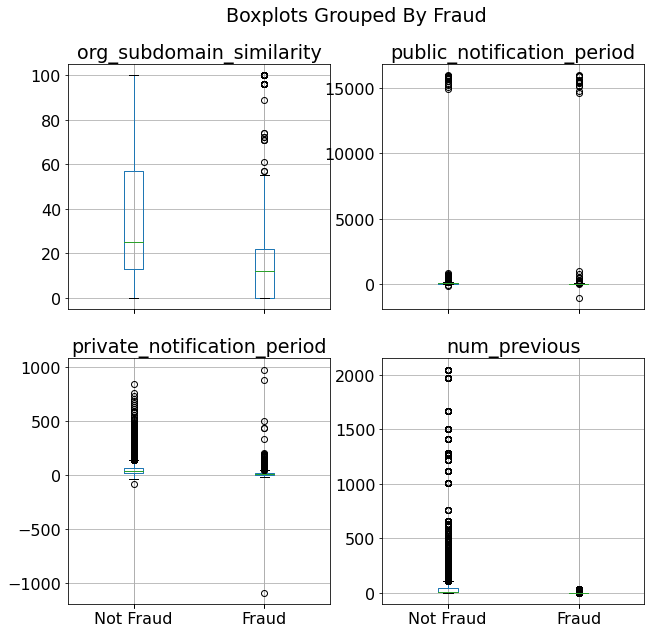

In [48]:
fig, ax_new = plt.subplots(2, 2, sharey=False, figsize=(10,10), sharex=True)
bp = df_new.boxplot(by="fraud", column=new_boxes, ax=ax_new,layout=(2, 2), figsize=(10, 10))
[ax_tmp.set_xlabel('') for ax_tmp in ax_new.reshape(-1)]
[ax_tmp.set_xticklabels(['Not Fraud','Fraud']) for ax_tmp in ax_new[1]]
# [ax_tmp.set_xlabel('Fraud') for ax_tmp in ax_new[2]]
fig.suptitle('Boxplots Grouped By Fraud')
# plt.tight_layout()
plt.savefig('images/boxplots_new.png')

In [ ]:
df.groupby(['payout_type','fraud'])['fraud'].count().unstack(0).plot.bar()

In [ ]:
df_for_models._get_numeric_data().columns

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

drop_list = ['acct_type', 'approx_payout_date', 'event_end', 'event_start', 'gts', 'num_payouts', 'payout_type', 'sale_duration', 'sale_duration2', 'ticket_types']
df_for_models = df.drop(drop_list, axis=1)
df_for_models.fillna(0, inplace=True)

In [ ]:
y = df_for_models.pop('fraud').values
X = df_for_models._get_numeric_data().values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.predict_proba(X_test)

In [ ]:
import pickle
# with open("data/model.pkl", 'w') as f:
pickle.dump(rf, open('data/model.pkl', 'wb'))

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, rf.predict(X_test))

In [ ]:
df.info()

In [ ]:
rand_list = np.random.randint(0, len(df), 10)
rand_list

In [ ]:
test_examples_df = df_for_models.loc[rand_list]

In [ ]:
test_examples_df.to_csv('data/test_script_examples.csv')

In [ ]:
df_mw = df[525:551]

In [ ]:
pd.set_option('display.max_columns', None)
df_mw.head()

In [ ]:
df_mw['email_domain'].value_counts()

In [ ]:
df_mw['email_._loc'] = df_mw['email_domain'].str.find('.')

In [ ]:
df_mw['email_domain'].str[-3:].value_counts()

In [ ]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(df_mw['description'][525], 'html.parser')

In [ ]:
p_list = soup.find_all('p')

In [ ]:
for p in p_list:
    print(p.get_text())

In [ ]:
df_mw['fraud'].count()

In [ ]:
df_mw[df_mw['fraud'] == 1]

In [ ]:
df['fraud'].sum()

In [ ]:
df[df['fraud'] == 1]['ticket_types'][0]

In [ ]:
df_mw['ticket_types'][527]

In [ ]:
(df_mw ['event_created'] - df_mw['user_created']) / df_mw['user_age']

In [ ]:
df_mw['user_age']

In [ ]:
(df_mw['event_end'] - df_mw['event_start'])/60000

In [ ]:
df_mw['event_published'] - df_mw['event_created']

In [ ]:
df_mw.head()

In [ ]:
df['user_age'][df['fraud'] == 1].value_counts()

In [ ]:
df['email_domain'].str[-3:][df['fraud'] == 1].value_counts()

In [ ]:
pd.set_option('display.max_rows', None)
df['email_domain'].str[-3:].value_counts()

In [ ]:
df['country'].value_counts()

In [ ]:
df['description'][2]